In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from preprocessing.simple_augment import DataAugment
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import os

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


# Load Data

In [5]:
PATH = "../Data/Train"

In [6]:
batch_size = 512
image_size = (128, 96)
seed = 123

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "../Data/Train",
    image_size=image_size,
    color_mode='rgb',
    batch_size=batch_size,
    seed=seed,
    shuffle=True
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../Data/Test",
    color_mode='rgb',
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    shuffle=True
)

class_names = train_data.class_names
print(class_names)

Found 172625 files belonging to 23 classes.
Found 58021 files belonging to 23 classes.
['Bangkok', 'Barcelona', 'Boston', 'Brussels', 'BuenosAires', 'Chicago', 'Lisbon', 'London', 'LosAngeles', 'Madrid', 'Medellin', 'Melbourne', 'MexicoCity', 'Miami', 'Minneapolis', 'OSL', 'Osaka', 'PRG', 'PRS', 'Phoenix', 'Rome', 'TRT', 'WashingtonDC']


In [7]:
train_data = train_data.map(lambda x, y: (preprocess_input(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (preprocess_input(x), y))

In [8]:
from preprocessing.simple_augment import DataAugment

DELTA = .3
CONTRAST = 3

t_aug = DataAugment(train_data)
train_augm = t_aug.augment_data(DELTA, CONTRAST)
v_aug = DataAugment(validation_dataset)
val_augm = v_aug.augment_data(DELTA, CONTRAST)

train_augm = train_augm.map(lambda x, y: (preprocess_input(x), y))
val_augm = val_augm.map(lambda x, y: (preprocess_input(x), y))

TypeError: Invalid shape (512, 128, 96, 3) for image data

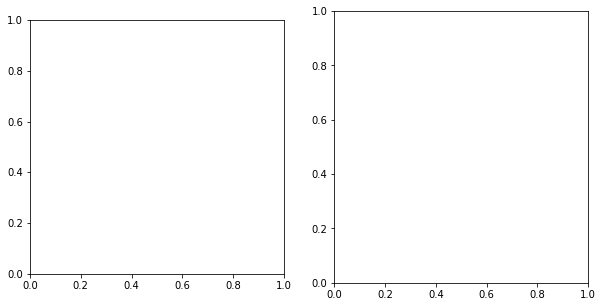

In [13]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Enable NumPy behavior in TensorFlow
tf.experimental.numpy.experimental_enable_numpy_behavior()

# Get one sample from the original training dataset
original_sample = next(iter(train_data))[0].numpy()  # Convert TensorFlow tensor to NumPy array

# Apply augmentation to the sample
augmented_sample = next(iter(t_aug.augment_data(DELTA, CONTRAST)))[0].numpy()  # Convert TensorFlow tensor to NumPy array

# Define a function to plot images
def plot_images(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original.astype("uint8"))
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(augmented.astype("uint8"))
    axes[1].set_title("Augmented")
    axes[1].axis("off")
    plt.show()

# Plot the original and augmented images
plot_images(original_sample, augmented_sample)


# Build Model

In [37]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import ResNet50

def build_model(input_shape, num_classes):

    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    #training some layers
    for layer in base_model.layers[:150]:
        layer.trainable = False

    for layer in base_model.layers[150:]:
        layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.Conv2D(1024, kernel_size=(2,2), activation="relu"),
        layers.GlobalAveragePooling2D(),
        layers.Dropout(.5),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax")
    ])

    optimizer = optimizers.Adam(learning_rate=.01)
    model.compile(optimizer='adam',
                 loss="sparse_categorical_crossentropy",
                 metrics=["accuracy"])

    return model

model = build_model((128, 96, 3), 23)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 3, 2048)        23587712  
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 2, 1024)        8389632   
                                                                 
 global_average_pooling2d_3   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 23)                23575     
                                                      

# Fit Model

## Try with augmented data first

In [19]:
# Assuming you have your model defined and compiled as 'model'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Train the model
epochs = 10
model.fit(train_augm, validation_data=val_augm, epochs=epochs)

Epoch 1/10
777/777 [==============================] - 849s 1s/step - loss: 1.6395 - accuracy: 0.5049 - val_loss: 1.2418 - val_accuracy: 0.6026
Epoch 2/10
777/777 [==============================] - 806s 1s/step - loss: 1.0395 - accuracy: 0.6661 - val_loss: 1.0822 - val_accuracy: 0.6582
Epoch 3/10
777/777 [==============================] - 788s 1s/step - loss: 0.7657 - accuracy: 0.7493 - val_loss: 1.0991 - val_accuracy: 0.6670
Epoch 4/10
777/777 [==============================] - 793s 1s/step - loss: 0.5392 - accuracy: 0.8200 - val_loss: 1.2082 - val_accuracy: 0.6703
Epoch 5/10
777/777 [==============================] - 791s 1s/step - loss: 0.3677 - accuracy: 0.8750 - val_loss: 1.3360 - val_accuracy: 0.6646
Epoch 6/10
777/777 [==============================] - 799s 1s/step - loss: 0.2565 - accuracy: 0.9127 - val_loss: 1.4956 - val_accuracy: 0.6689
Epoch 7/10
777/777 [==============================] - 796s 1s/step - loss: 0.1924 - accuracy: 0.9342 - val_loss: 1.5346 - val_accuracy: 0.6732

## Unaugmented data

In [38]:
model2 = build_model((128, 96, 3), 23)
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 3, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 3, 2, 1024)        8389632   
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 flatten_4 (Flatten)         (None, 1024)              0         
                                                                 
 dense_4 (Dense)             (None, 23)                23575     
                                                      

In [39]:
# Assuming you have your model defined and compiled as 'model'
physical_devices = tf.config.experimental.list_physical_devices('GPU')

# Train the model
epochs = 5
model2.fit(train_data, validation_data=validation_dataset, epochs=epochs)

Epoch 1/5
777/777 [==============================] - 711s 905ms/step - loss: 1.6318 - accuracy: 0.5157 - val_loss: 1.2615 - val_accuracy: 0.6110
Epoch 2/5
777/777 [==============================] - 704s 899ms/step - loss: 1.0523 - accuracy: 0.6704 - val_loss: 1.1359 - val_accuracy: 0.6484
Epoch 3/5
777/777 [==============================] - 707s 903ms/step - loss: 0.7599 - accuracy: 0.7559 - val_loss: 1.0975 - val_accuracy: 0.6716
Epoch 4/5
777/777 [==============================] - 710s 906ms/step - loss: 0.5240 - accuracy: 0.8281 - val_loss: 1.2502 - val_accuracy: 0.6685
Epoch 5/5
777/777 [==============================] - 709s 906ms/step - loss: 0.3556 - accuracy: 0.8811 - val_loss: 1.3525 - val_accuracy: 0.6717


In [48]:
model2.save("resLast20_2.keras")

# Test Model

In [20]:
mappings = {'Buenos Aires': 'BuenosAires', 'Los Angeles': 'LosAngeles', 'Mexico City': 'MexicoCity', 'Oslo': 'OSL', 'Prague': 'PRG',
                'Paris': 'PRS', 'Toronto':'TRT', 'Washington':'WashingtonDC'}
for city in os.listdir('street_images_plid'):
    if city in mappings:
        os.rename('street_images_plid/'+city, 'street_images_plid/'+mappings[city])

In [85]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../street_images_plid",
    color_mode='rgb',
    image_size=(128, 96)
)
#t_aug = DataAugment(test_dataset)
#test_augm = t_aug.augment_data(DELTA, CONTRAST)

#test_augm = test_augm.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

Found 3319 files belonging to 23 classes.


In [84]:
model3 = tf.keras.models.load_model('../resLast20.keras')

In [86]:
model3.evaluate(test_dataset)

104/104 [==============================] - 4s 26ms/step - loss: 4.6781 - accuracy: 0.4067


[4.678134441375732, 0.40674901008605957]

# Confusion Matrices

In [59]:
pred_labels_all = []
actual_labels_all = []

for x_batch, y_batch in test_dataset:
    pred_probs_batch = model3.predict(x_batch)
    pred_labels_batch = np.argmax(pred_probs_batch, axis=1)
    pred_labels_all.extend(pred_labels_batch)
    actual_labels_all.extend(y_batch.numpy()) 

pred_labels_all = np.array(pred_labels_all)
actual_labels_all = np.array(actual_labels_all)


1/1 [==============================] - 0s 24ms/step


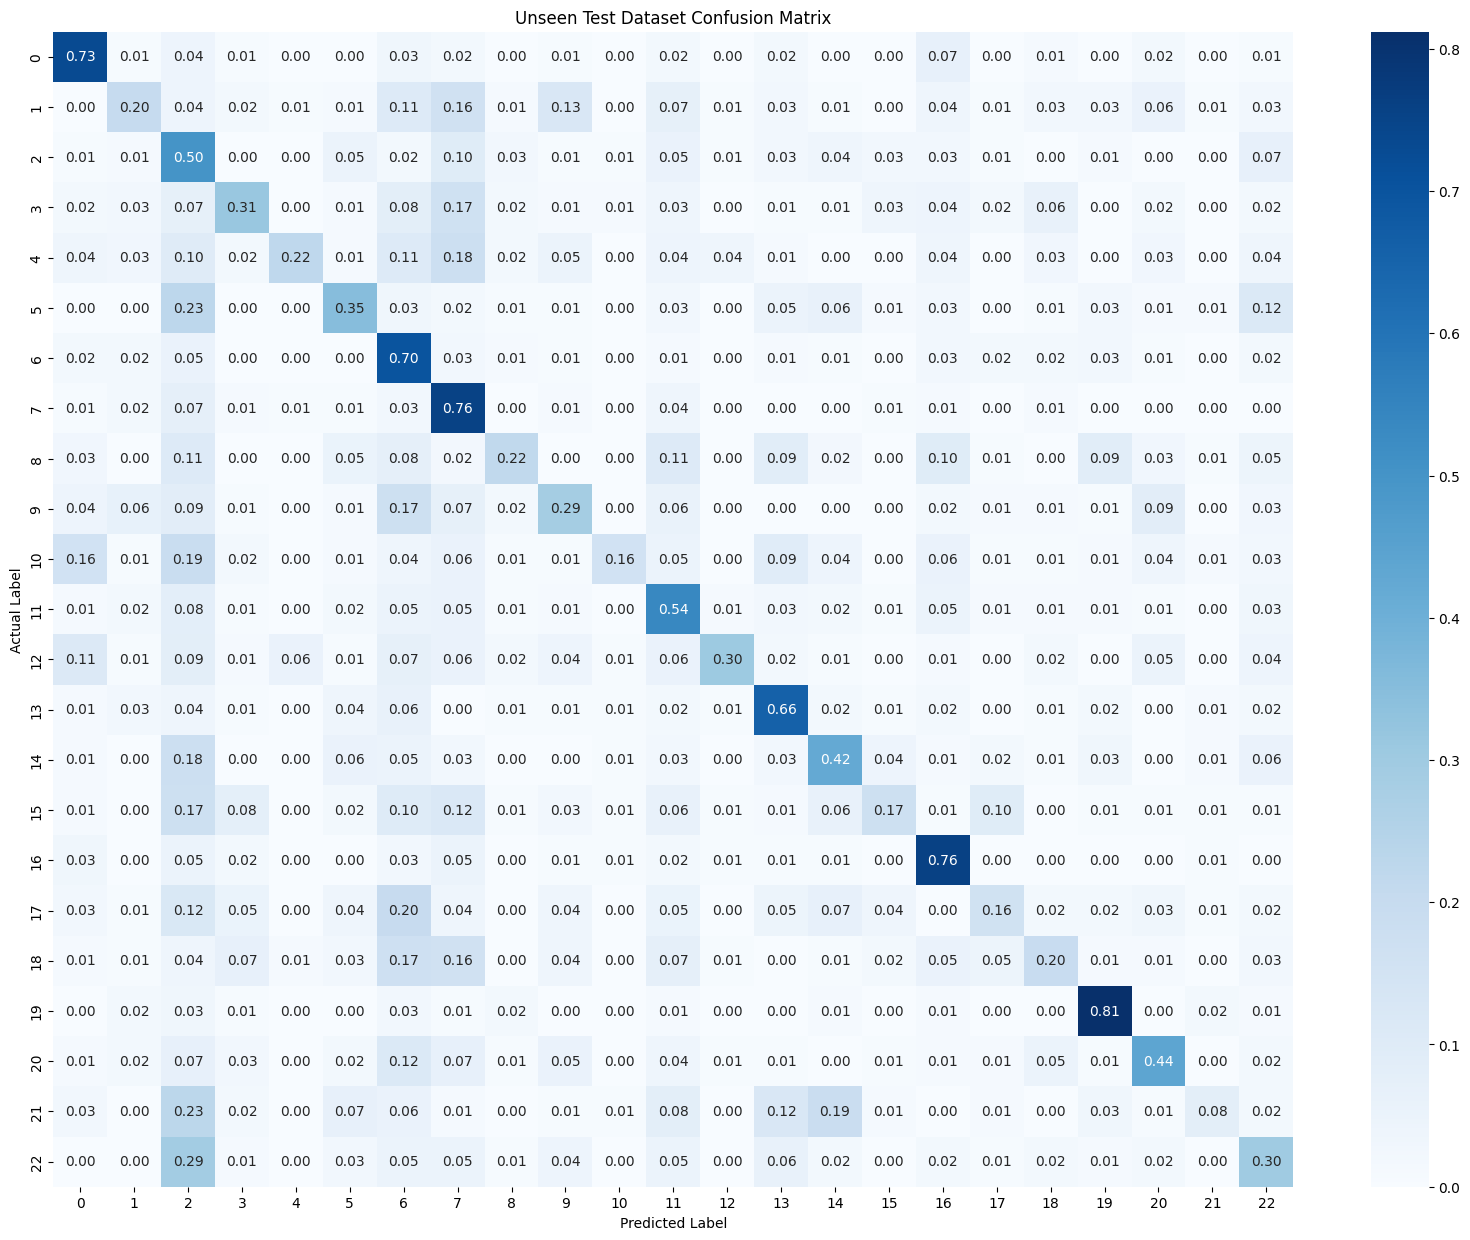

In [69]:
conf_matrix = confusion_matrix(actual_labels_all, pred_labels_all)

total_samples = len(actual_labels_all)

conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(20, 15))
sns.heatmap(conf_matrix_norm, annot=True, cmap='Blues', fmt='.2f')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Unseen Test Dataset Confusion Matrix')
plt.show()